In [1]:
!pip install datasets
!pip install nltk
!pip install emoji
!pip install contractions
!pip install beautifulsoup4
!pip install textblob
!pip install wordcloud
!pip install gensim
!pip install tensorflow


import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

import re
import datasets
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import emoji
import contractions

from bs4 import BeautifulSoup
from textblob import TextBlob

import multiprocessing

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.util import ngrams
from collections import Counter

from wordcloud import WordCloud

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.feature_extraction.text import TfidfVectorizer

import gensim
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Input, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix


2024-10-21 05:13:59.938217: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-21 05:14:01.215872: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
ds = datasets.load_dataset("stanfordnlp/imdb")
print(ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [3]:
df_train = ds['train'].to_pandas()
df_test = ds['test'].to_pandas()

display(df_train)

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0
...,...,...
24995,A hit at the time but now better categorised a...,1
24996,I love this movie like no other. Another time ...,1
24997,This film and it's sequel Barry Mckenzie holds...,1
24998,'The Adventures Of Barry McKenzie' started lif...,1


# Pre-processing

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
def normalize_text(text):
    # Expand contractions (like I'm -> I am)
    text = contractions.fix(text)
    
    # Lowercasing
    text = text.lower()    
    
    # Remove HTML syntaxes
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove emojis
    text = emoji.replace_emoji(text, replace='')
    
    # Remove punctuation and underscores
    text = re.sub(r'[^\w\s]|_', '', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())

    return text


In [6]:
# Use all cores to normalize the text
with multiprocessing.Pool() as pool:
    df_train['text'] = pool.map(normalize_text, df_train['text'])
    df_test['text'] = pool.map(normalize_text, df_test['text'])

display(df_train)

/tmp/ipykernel_38809/1628194200.py:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')
/tmp/ipykernel_38809/1628194200.py:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')
/tmp/ipykernel_38809/1628194200.py:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')
/tmp/ipykernel_38809/1628194200.py:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')
/tmp/ipykernel_38809/1628194200.py:9: Markup

,text,label
0,i rented i am curiousyellow from my video stor...,0
1,i am curious yellow is a risible and pretentio...,0
2,if only to avoid making this type of film in t...,0
3,this film was probably inspired by godards mas...,0
4,oh brotherafter hearing about this ridiculous ...,0
...,...,...
24995,a hit at the time but now better categorised a...,1
24996,i love this movie like no other another time i...,1
24997,this film and it is sequel barry mckenzie hold...,1
24998,the adventures of barry mckenzie started life ...,1


In [7]:
def tokenize(text):
    # Tokenization
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    
    return tokens

In [8]:
# Tokenize and lemmatize the text using all cores
with multiprocessing.Pool() as pool:
    df_train['text'] = pool.map(tokenize, df_train['text'])
    df_test['text'] = pool.map(tokenize, df_test['text'])

display(df_train)

,text,label
0,"[rented, curiousyellow, video, store, controve...",0
1,"[curious, yellow, risible, pretentious, steami...",0
2,"[avoid, making, type, film, future, film, inte...",0
3,"[film, probably, inspired, godards, masculin, ...",0
4,"[oh, brotherafter, hearing, ridiculous, film, ...",0
...,...,...
24995,"[hit, time, better, categorised, australian, c...",1
24996,"[love, movie, like, another, time, try, explai...",1
24997,"[film, sequel, barry, mckenzie, holds, two, gr...",1
24998,"[adventures, barry, mckenzie, started, life, s...",1


# Dataset Statistics and Visualization

Inspired by https://www.kaggle.com/code/colearninglounge/nlp-data-preprocessing-and-cleaning/notebook#Word2Vec-and-its-variants

In [9]:
# Document count
print("The training data contains", df_train.shape[0], "reviews.")
print("The test data contains", df_test.shape[0], "reviews.")

The training data contains 25000 reviews.
The test data contains 25000 reviews.


In [10]:
# Word count
df_train['word_count'] = df_train['text'].apply(len)
print("The pre-processed training data contains", df_train['word_count'].sum(), "words (without stop words).")

The pre-processed training data contains 2939809 words (without stop words).


In [11]:
# Label count to check if training and test data are balanced
print("The distribution of labels in the training data is: \n", df_train['label'].value_counts())
print("The distribution of labels in the test data is: \n", df_test['label'].value_counts())

The distribution of labels in the training data is: 
 label
0    12500
1    12500
Name: count, dtype: int64
The distribution of labels in the test data is: 
 label
0    12500
1    12500
Name: count, dtype: int64


In [12]:
# Unique token count
unique_tokens = set([token for review in df_train['text'] for token in review])
print("The pre-processed training data contains", len(unique_tokens), "unique tokens (without stopwords).")

The pre-processed training data contains 137086 unique tokens (without stopwords).


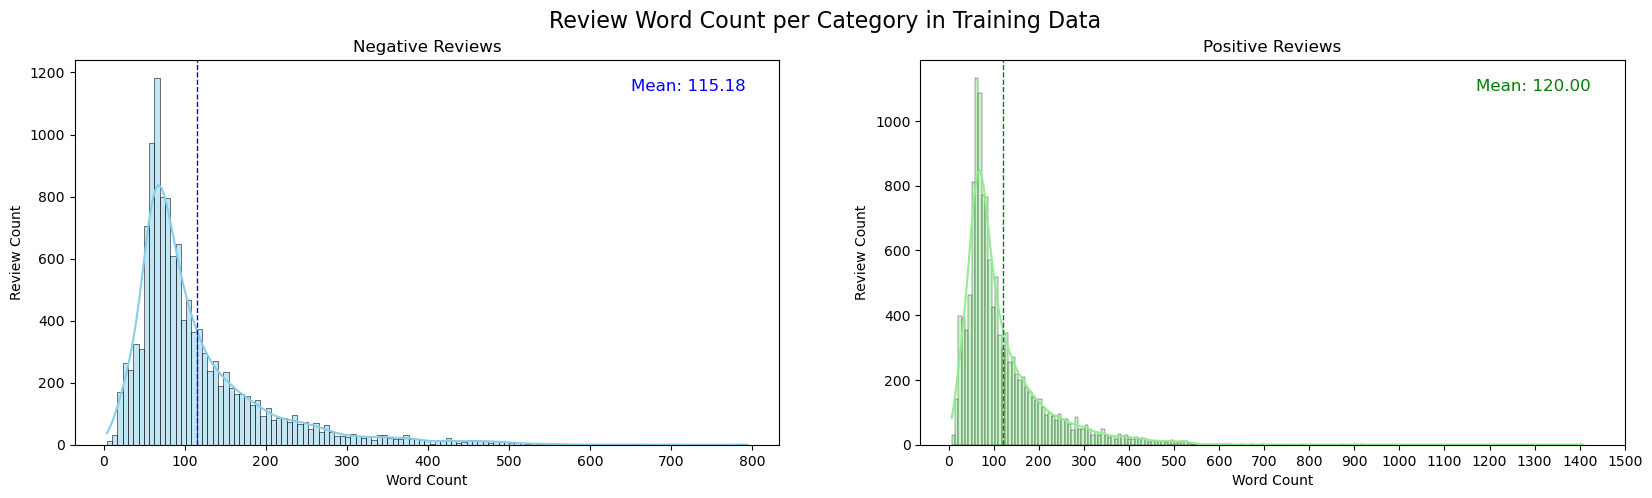

In [13]:
# Distribution of review length per category in training data
neg_reviews = df_train[df_train['label']==0]
pos_reviews = df_train[df_train['label']==1]

# Define the plot function
# Smooth curve represents the estimated probability density function of the variable
def plot_count(count_first, count_second, title_1, title_2, subtitle):
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    
    def subplot(ax, color_plot, color_mean, title, count):
        sns.histplot(count, ax=ax, color=color_plot, kde=True)
        ax.set_title(title)
        ax.set_xlabel("Word Count")
        ax.set_ylabel("Review Count")
        ax.set_xticks(np.arange(0, max(count) + 100, 100))
        mean = np.mean(count)
        ax.axvline(mean, color=color_mean, linestyle='dashed', linewidth=1)
        place_x = ax.get_xlim()[1] * 0.95
        place_y = ax.get_ylim()[1] * 0.95
        ax.annotate(f'Mean: {mean:.2f}', xy=(place_x, place_y), xycoords='data',
                    xytext=(place_x, place_y), textcoords='data', ha='right', va='top', 
                    fontsize=12, color=color_mean)
        
    subplot(axs[0], 'skyblue', 'b', title_1, count_first)
    subplot(axs[1], 'lightgreen', 'g', title_2, count_second)
    fig.suptitle(subtitle, fontsize=16)
    plt.show()

plot_count(neg_reviews['word_count'], pos_reviews['word_count'],
              'Negative Reviews', 'Positive Reviews', 'Review Word Count per Category in Training Data')


In [14]:
# Trim reviews to a maximum length of 600 tokens
max_sequence_length = 600

df_train['text'] = df_train['text'].apply(lambda x: x[:max_sequence_length])
df_test['text'] = df_test['text'].apply(lambda x: x[:max_sequence_length])

In [15]:
# n-grams

def get_ngrams(text, n):
    n_grams = ngrams(text, n)
    return [' '.join(grams) for grams in n_grams]   

def get_ngram_list(df, n):
    ngram_list = df['text'].apply(lambda x: get_ngrams(x, n))
    return [ngram for sublist in ngram_list for ngram in sublist]

def get_most_common_ngrams(df, n, top_n):
    ngram_list = get_ngram_list(df, n)
    ngram_freq = Counter(ngram_list)
    return ngram_freq.most_common(top_n)

def n_gram_visualization(n, top_n, name):
    neg_ngrams = get_most_common_ngrams(neg_reviews, n, top_n)
    pos_ngrams = get_most_common_ngrams(pos_reviews, n, top_n)
    neg_ngrams, neg_freq = zip(*neg_ngrams)
    pos_ngrams, pos_freq = zip(*pos_ngrams)
    
    def subplot(ax, title, ngrams, frequency):
        sns.barplot(x=frequency, y=ngrams, palette='viridis', hue=ngrams,legend=False, ax=ax)
        ax.set_title(title)
        ax.set_xlabel("Frequency")
    
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))
    
    subplot(axs[0], 'Negative Reviews', neg_ngrams, neg_freq)
    subplot(axs[1], 'Positive Reviews', pos_ngrams, pos_freq)
    fig.suptitle(f"Top {top_n} {name} per Category in Training Data", fontsize=16)
    plt.tight_layout()
    plt.show()

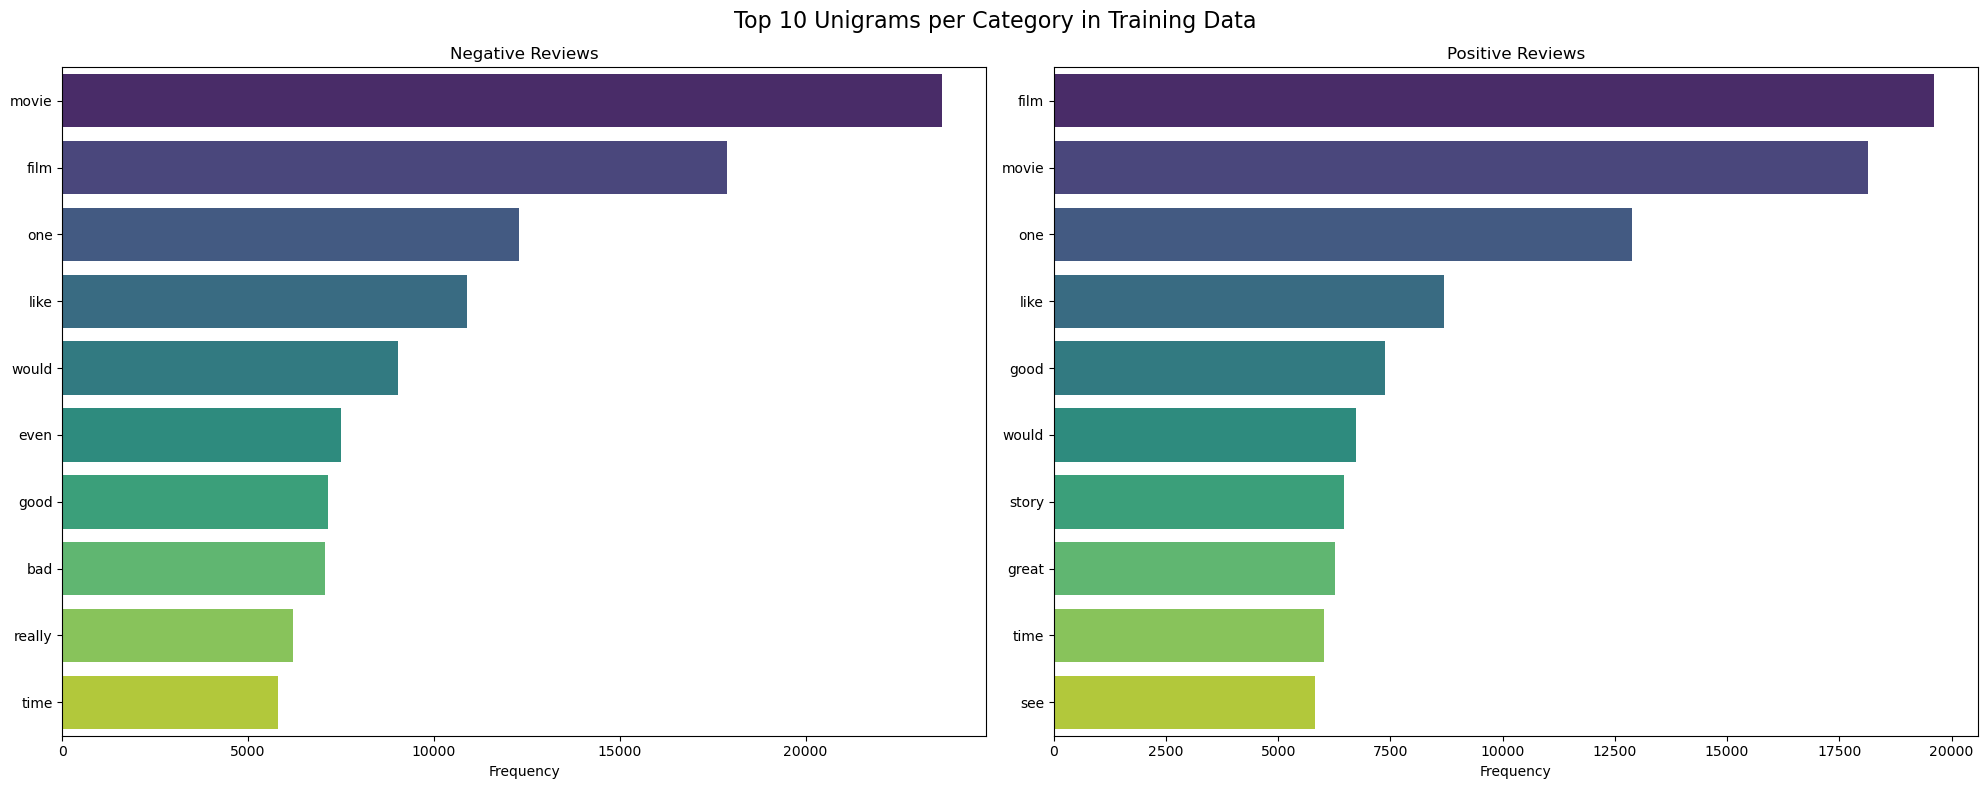

In [16]:
# Visualize unigrams
n_gram_visualization(1, 10, 'Unigrams')

The training data contains 2911985 bigrams and 1825886 unique bigrams.


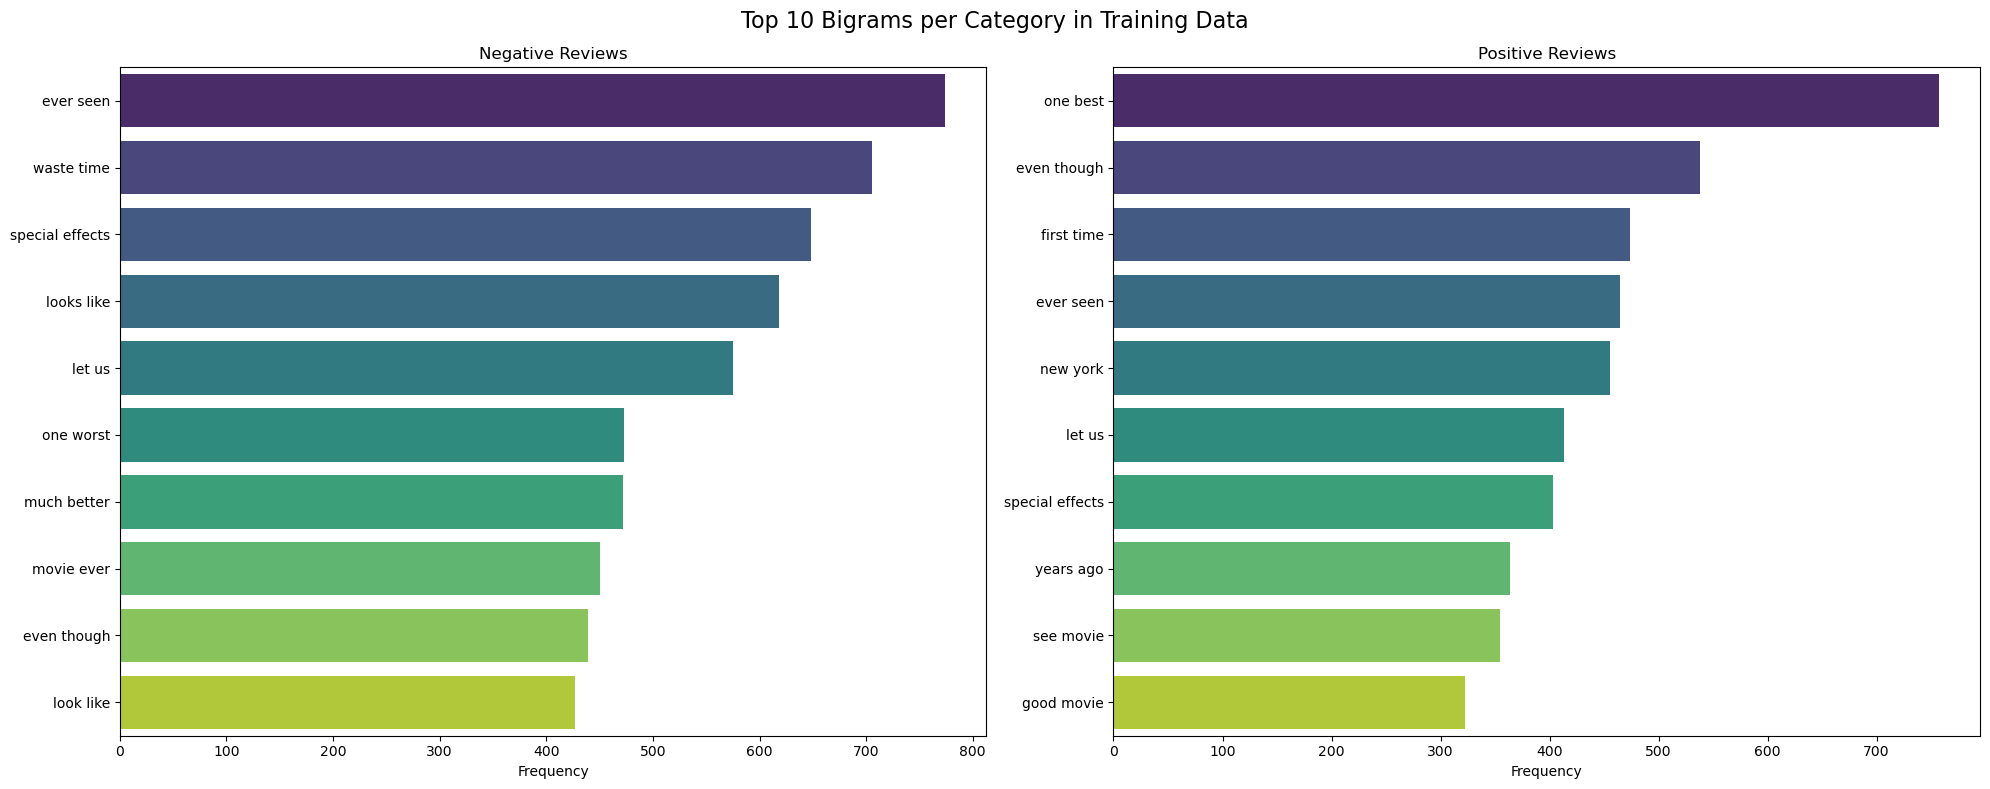

In [17]:
# Number of bigrams
bigram_list = get_ngram_list(df_train, 2)
print("The training data contains", len(bigram_list), "bigrams and", len(set(bigram_list)), "unique bigrams.")

# Visualize bigrams
n_gram_visualization(2, 10, 'Bigrams')

In [18]:
# Word cloud

def plot_word_cloud(text, title):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(text) 
      
    # plot the WordCloud image                        
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title)
  
    plt.show()
 

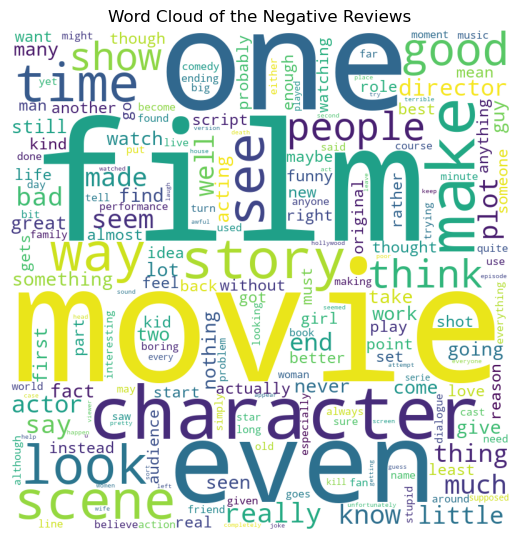

In [19]:
# Negative reviews
# Create a text from the tokenized text and visualize as word cloud
text = ' '.join([' '.join(x) for x in neg_reviews['text']])
plot_word_cloud(text, "Word Cloud of the Negative Reviews")

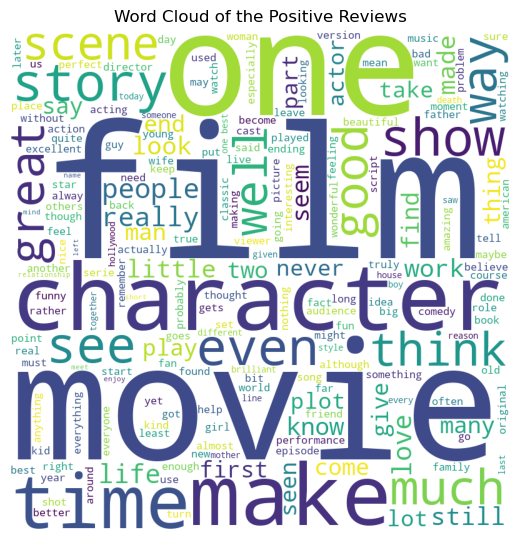

In [20]:
# Positive reviews
# Create a text from the tokenized text and visualize as word cloud
text = ' '.join([' '.join(x) for x in pos_reviews['text']])
plot_word_cloud(text, "Word Cloud of the Positive Reviews")

# Classification

### Neural Networks with Word2Vec Embeddings

In [21]:
# Convert the text column into a list of token lists
reviews_train = df_train['text'].tolist()

# Train the Word2Vec model
word2vec_model = gensim.models.Word2Vec(reviews_train, vector_size=300, window=5, min_count=1, sg=0)
word2vec_model.train(reviews_train, total_examples=len(reviews_train), epochs=10)

# Create word index dictionary
word_index = {}
for review in reviews_train:
    for word in review:
        if word not in word_index:
            word_index[word] = len(word_index) + 1

vocab_size = len(word_index) + 1
print("Vocabulary Size:", vocab_size)

# Convert reviews to sequences of word indices
sequences_train = [[word_index[word] for word in review] for review in reviews_train]
# Pad sequences to the same length to create training data
X_train_padded = pad_sequences(sequences_train, maxlen=max_sequence_length, padding='post')

# Check that X_train_padded has correct shape (number of reviews, max_sequence_length) and contains integer indices
print("X_train_padded shape:", X_train_padded.shape)
print("X_train_padded:", X_train_padded)
print()

# Create the embedding matrix containing Word2Vec vectors
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word] #if the word is in the word2vec model, add the vector to the embedding matrix

print("Embedding Matrix Shape:", embedding_matrix.shape)
print("Embedding Matrix:", embedding_matrix)


Vocabulary Size: 137020
X_train_padded shape: (25000, 600)
X_train_padded: [[    1     2     3 ...     0     0     0]
 [  121   122   123 ...     0     0     0]
 [  218    42   219 ...     0     0     0]
 ...
 [  103  4765 11169 ...     0     0     0]
 [ 8789 11169 43014 ...     0     0     0]
 [  543 11045    28 ...     0     0     0]]

Embedding Matrix Shape: (137020, 300)
Embedding Matrix: [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.66812605  1.18505943 -0.34121698 ...  0.47667122  0.87652236
   1.26282597]
 [ 0.04360679  0.07900048 -0.00928948 ... -0.02530983  0.02849751
  -0.00289751]
 ...
 [-0.01098237  0.05077069  0.01579977 ... -0.01115112 -0.01813358
  -0.00575867]
 [ 0.03956211 -0.0278923   0.03584249 ... -0.05215045 -0.02546576
   0.04432717]
 [-0.00778206  0.01733994  0.01862483 ...  0.0073451   0.00966907
  -0.02194445]]


In [22]:
# Process the test data in the same way as before, using the word index from the training data
reviews_test = df_test['text'].tolist()
sequences_test = [[word_index[word] if word in word_index else 0 for word in review] for review in reviews_test]
X_test_padded = pad_sequences(sequences_test, maxlen=max_sequence_length, padding='post')

## Base Model without Dropout

In [23]:
# Define the Feedforward Neural Network without dropout, using the embedding matrix as weights for the embedding layer

base_model = Sequential()
base_model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
base_model.add(Flatten())
base_model.add(Dense(1024, activation='relu'))
base_model.add(Dense(512, activation='relu'))
base_model.add(Dense(256, activation='relu'))
base_model.add(Dense(128, activation='relu'))
base_model.add(Dense(1, activation='sigmoid'))

base_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [25]:
# Plot the training process 
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    
    axs[0].plot(history.history['accuracy'], label='Training Accuracy')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[0].set_title('Training and Validation Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(loc='lower right')
    
    axs[1].plot(history.history['loss'], label='Training Loss')
    axs[1].plot(history.history['val_loss'], label='Validation Loss')
    axs[1].set_title('Training and Validation Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend(loc='upper right')
    
    plt.show()

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 118s 378ms/step - accuracy: 0.9886 - loss: 0.0310 - val_accuracy: 0.6958 - val_loss: 1.7137
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 118s 378ms/step - accuracy: 0.9940 - loss: 0.0174 - val_accuracy: 0.6308 - val_loss: 2.8078
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 119s 379ms/step - accuracy: 0.9946 - loss: 0.0164 - val_accuracy: 0.7268 - val_loss: 2.1366
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 118s 378ms/step - accuracy: 0.9957 - loss: 0.0125 - val_accuracy: 0.6452 - val_loss: 3.6275
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 119s 379ms/step - accuracy: 0.9936 - loss: 0.0237 - val_accuracy: 0.6576 - val_loss: 2.0336
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 118s 378ms/step - accuracy: 0.9979 - loss: 0.0076 - val_accuracy: 0.6218 - val_loss: 2.6580
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 118s 378ms/step - accuracy: 0.9971 - loss: 0.0090 - val_accuracy: 0.6582 - val_loss: 1.8716
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 118s 378ms/step - accuracy: 0.9988 -

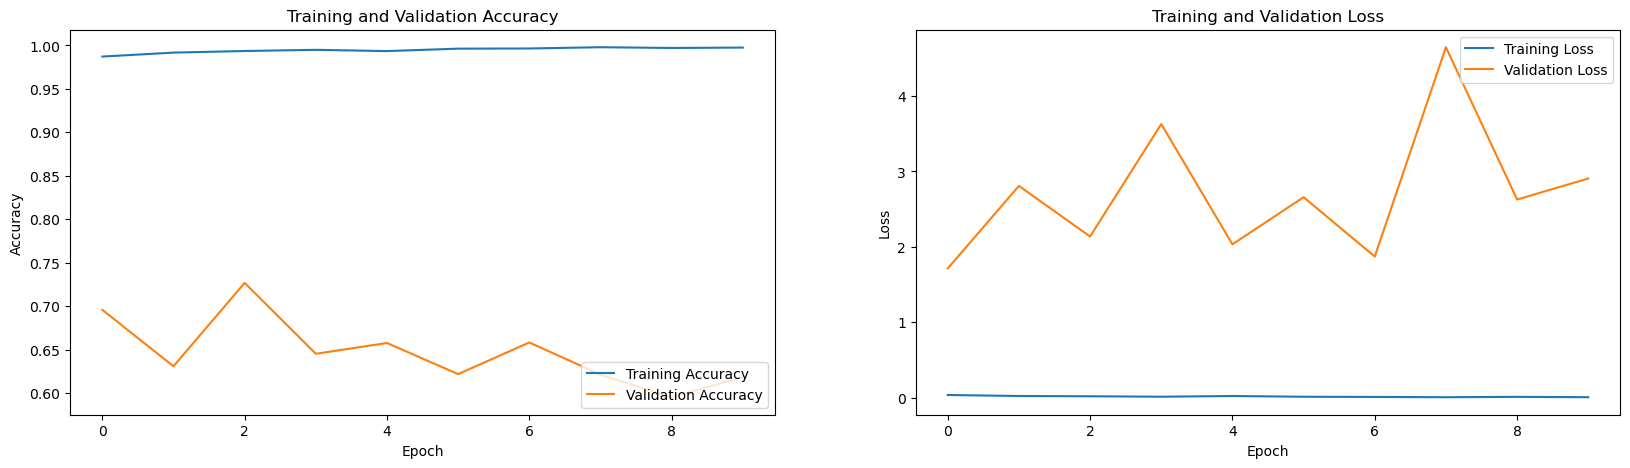

In [26]:
# Train the model without early stopping and visualize the training process

history_base = base_model.fit(X_train_padded, 
               df_train['label'], 
               epochs=10, 
               batch_size=64, 
               validation_split=0.2)

plot_history(history_base)

In [27]:
# Evaluate the model on the test data
y_base_pred = base_model.predict(X_test_padded)
y_base_pred = np.where(y_base_pred > 0.5, 1, 0) #convert the probabilities to binary labels

782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step


In [28]:
# Visualize the confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

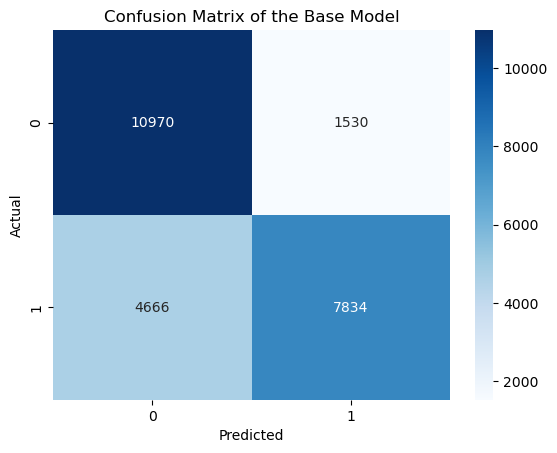

In [29]:
# Visualize the confusion matrix
plot_confusion_matrix(df_test['label'], y_base_pred, "Confusion Matrix of the Base Model")

In [30]:
# Calculate the metrics
accuracy_base = accuracy_score(df_test['label'], y_base_pred)
f1_base = f1_score(df_test['label'], y_base_pred)
precision_base = precision_score(df_test['label'], y_base_pred)
recall_base = recall_score(df_test['label'], y_base_pred)

print("The accuracy of the base model is {:.4f}".format(accuracy_base))
print("The f1 score of the base model is {:.4f}".format(f1_base))
print("The precision of the base model is {:.4f}".format(precision_base))
print("The recall of the base model is {:.4f}".format(recall_base))

The accuracy of the base model is 0.7522
The f1 score of the base model is 0.7166
The precision of the base model is 0.8366
The recall of the base model is 0.6267


## Model with Dropout

In [35]:
# Choose dropout rate by cross-validation

# Define the model with dropout
def create_model(dropout_rate):
    model = Sequential()
    model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Define the cross-validation function
def cross_validation(dropout_rate):
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []
    print("Dropout rate:", dropout_rate)

    
    for train, val in kfold.split(X_train_padded, df_train['label']):
        model = create_model(dropout_rate)
        model.fit(X_train_padded[train], df_train['label'][train], epochs=3, batch_size=64)
        _, accuracy = model.evaluate(X_train_padded[val], df_train['label'][val], verbose=0)
        cv_scores.append(accuracy)
    
    return np.mean(cv_scores)

# Find the optimal dropout rate
dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]
cv_results = []

for rate in dropout_rates:
    cv_results.append(cross_validation(rate))

best_dropout_rate = dropout_rates[np.argmax(cv_results)]
print("The best dropout rate is:", best_dropout_rate)

Dropout rate: 0.1
Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 124s 370ms/step - accuracy: 0.6950 - loss: 0.6232
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 116s 370ms/step - accuracy: 0.9184 - loss: 0.2105
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 116s 370ms/step - accuracy: 0.9833 - loss: 0.0502
Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 124s 370ms/step - accuracy: 0.6894 - loss: 0.6140
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 115s 369ms/step - accuracy: 0.9169 - loss: 0.2086
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 116s 369ms/step - accuracy: 0.9802 - loss: 0.0613
Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 125s 369ms/step - accuracy: 0.7071 - loss: 0.6038
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 115s 369ms/step - accuracy: 0.9149 - loss: 0.2173
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 116s 369ms/step - accuracy: 0.9851 - loss: 0.0476
Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 124s 369ms/step - accuracy: 0.6967 - loss: 0.6295
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 115s 369ms/step - accuracy: 0.9208 - loss: 0.2103
Epo

In [36]:
# Create the model with the best dropout rate

dropout_model = create_model(best_dropout_rate)

dropout_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 127s 379ms/step - accuracy: 0.5981 - loss: 0.9388 - val_accuracy: 0.5556 - val_loss: 0.7146
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 118s 377ms/step - accuracy: 0.8032 - loss: 0.4953 - val_accuracy: 0.6494 - val_loss: 0.5894
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 118s 378ms/step - accuracy: 0.8893 - loss: 0.2959 - val_accuracy: 0.5418 - val_loss: 1.0310
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 118s 378ms/step - accuracy: 0.9440 - loss: 0.1730 - val_accuracy: 0.6680 - val_loss: 0.8596
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 118s 377ms/step - accuracy: 0.9640 - loss: 0.1115 - val_accuracy: 0.6218 - val_loss: 1.4600
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 118s 378ms/step - accuracy: 0.9751 - loss: 0.0821 - val_accuracy: 0.6568 - val_loss: 1.0952
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 118s 378ms/step - accuracy: 0.9805 - loss: 0.0599 - val_accuracy: 0.6132 - val_loss: 1.8848
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 118s 377ms/step - accuracy: 0.9854 -

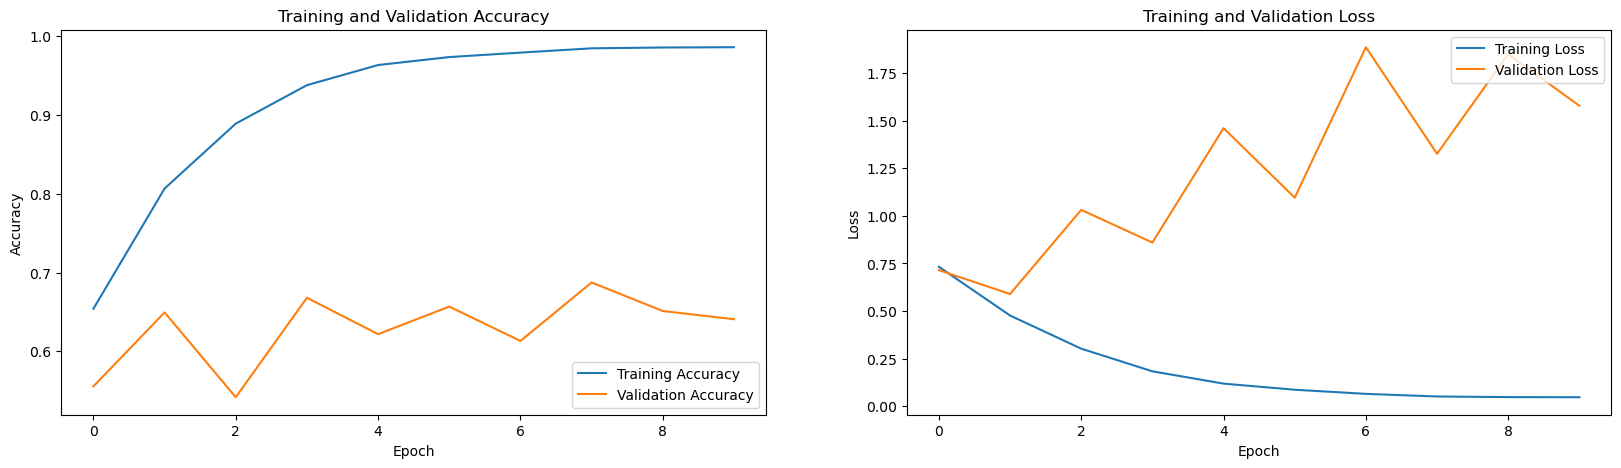

In [37]:
# Train the resulting model on the whole data set and visualize the training process

history_drop = dropout_model.fit(X_train_padded, 
                                 df_train['label'], 
                                 epochs=10, 
                                 batch_size=64, 
                                 validation_split=0.2)

plot_history(history_drop)


In [38]:
# Evaluate the model on the test data
y_drop_pred = dropout_model.predict(X_test_padded)
y_drop_pred = np.where(y_drop_pred > 0.5, 1, 0) #convert the probabilities to binary labels

782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step


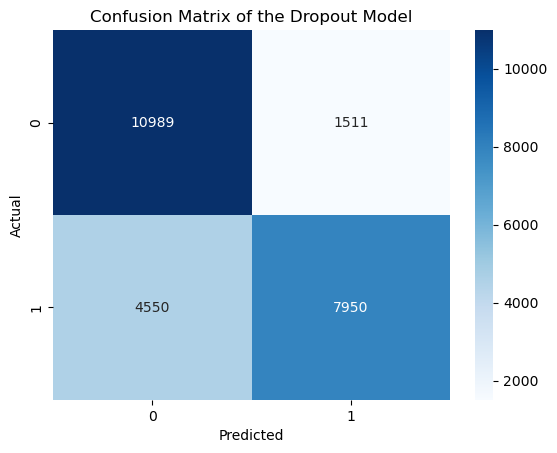

In [39]:
# Visualize the confusion matrix
plot_confusion_matrix(df_test['label'], y_drop_pred, "Confusion Matrix of the Dropout Model")

In [40]:
# Calculate the metrics
accuracy_drop = accuracy_score(df_test['label'], y_drop_pred)
f1_drop = f1_score(df_test['label'], y_drop_pred)
precision_drop = precision_score(df_test['label'], y_drop_pred)
recall_drop = recall_score(df_test['label'], y_drop_pred)

print("The accuracy of the Neural Network model with Dropout is {:.4f}".format(accuracy_drop))
print("The f1 score of the Neural Network model with Dropout is {:.4f}".format(f1_drop))
print("The precision of the Neural Network model with Dropout is {:.4f}".format(precision_drop))
print("The recall of the Neural Network model with Dropout is {:.4f}".format(recall_drop))

The accuracy of the Neural Network model with Dropout is 0.7576
The f1 score of the Neural Network model with Dropout is 0.7240
The precision of the Neural Network model with Dropout is 0.8403
The recall of the Neural Network model with Dropout is 0.6360


## Comparison between Base Model and Model with Dropout

,Model,Accuracy,F1 Score,Precision,Recall
0,Base Model,0.75216,0.716612,0.836608,0.62672
1,Model with Dropout,0.75756,0.724011,0.840292,0.63600


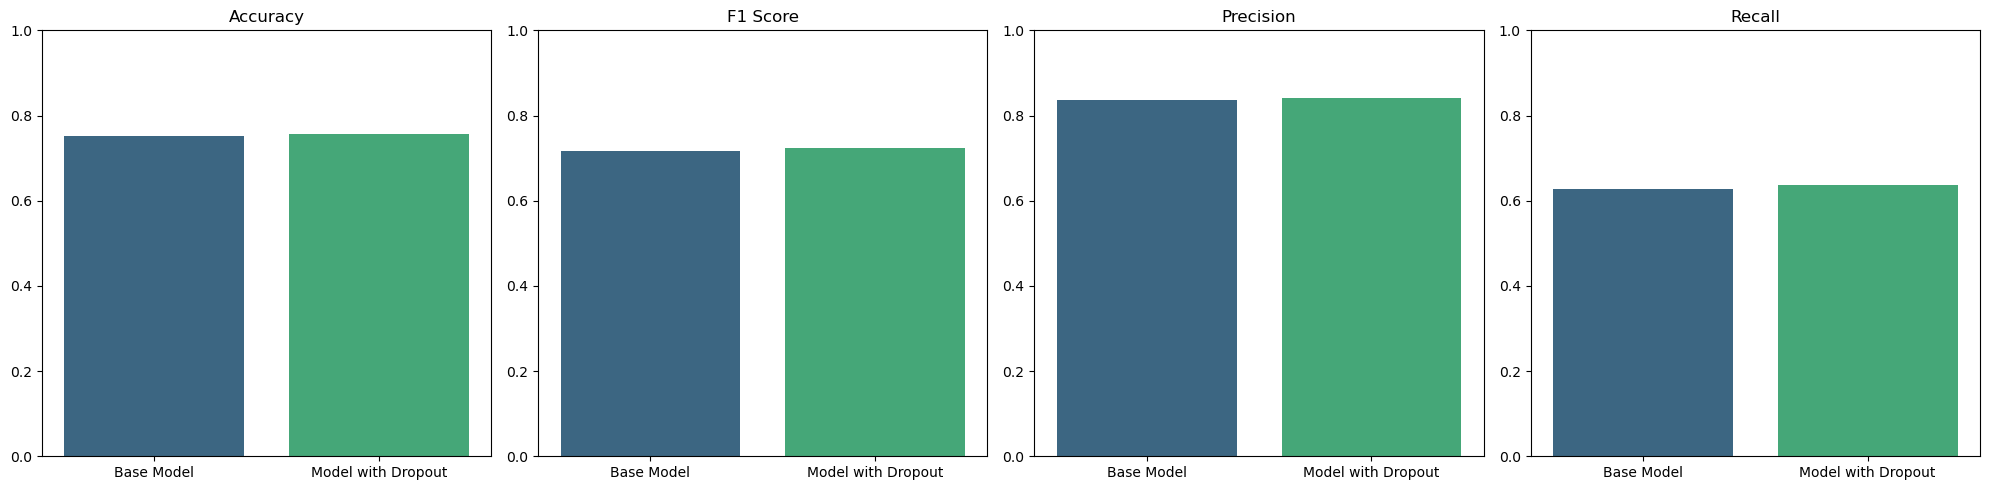

In [41]:
# Compare the models

# Create a DataFrame with the metrics
metrics = pd.DataFrame({'Model': ['Base Model', 'Model with Dropout'],
                         'Accuracy': [accuracy_base, accuracy_drop],
                         'F1 Score': [f1_base, f1_drop],
                         'Precision': [precision_base, precision_drop],
                         'Recall': [recall_base, recall_drop]})

# Display the metrics
display(metrics)

# Plot the metrics
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

def plot_metric(ax, metric, title):
    sns.barplot(x='Model', y=metric, data=metrics, palette='viridis', hue='Model', ax=ax)
    ax.set_title(title)
    ax.set_ylim(0, 1)
    ax.set_xlabel(None)
    ax.set_ylabel(None)

plot_metric(axs[0], 'Accuracy', 'Accuracy')
plot_metric(axs[1], 'F1 Score', 'F1 Score')
plot_metric(axs[2], 'Precision', 'Precision')
plot_metric(axs[3], 'Recall', 'Recall')

plt.tight_layout()